# Adaptive Multilevel Splitting (AMS)
ANR SINEQ, Summer School, 09/27/2023

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from time import perf_counter, sleep
from IPython.display import clear_output

## Part 1: The Static Framework

To illustrate the last particle algorithm, we consider the following toy example: we want to estimate the probability $p:=\mathbb{P}(\mathcal{N}(0,1)>q)$, with $q$ such that $p$ is very low. For this, we just need a transition kernel $P$ that is reversible wrt $\mathcal{N}(0,1)$, for example a Gaussian kernel. Specifically, starting from $X$, this kernel proposes the transition to the position $\rho X+\sqrt{1-\rho^2}W$, with $W\sim\mathcal{N}(0,1)$ independent of $X$ and $\rho\in(0,1)$ a tuning parameter. 

For a given level $L$, if $X\sim\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$, then
\begin{equation*}
X':= \begin{cases}\rho X+\sqrt{1-\rho^2} W &\textrm{ if $\rho X+\sqrt{1-\rho^2} W>L$}\\ X&\textrm{otherwise}\end{cases} 
\end{equation*}
still satisfies $X'\sim\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$. Thus, if we apply a "huge" number of times $T$ this kernel, we obtain a new point that is still distributed according to $\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$ and "almost independent" of the initial point $X$.

Let us recall the idea of the algorithm: we begin with an $n$ i.i.d. sample with law $\mathcal{N}(0,1)$ and, at each step, we compute the score $L$ of the less relevant particle (i.e., the minimum), we kill it and clone one of the $(n-1)$ other ones (randomly uniformly chosen), then we apply $T$ times to this clone the transition kernel, and so on until step $J_n:= \max \{j: L_j  \leq q \}$. The estimator of $p$ is then simply :
$$\hat p_n:=\left(1-\frac{1}{n}\right)^{J_n}.$$
In the so-called "ideal" case, we would apply an infinite number of times the transition kernel and would have the following CLT type result:
$$\sqrt{n}\left(\hat p_n-p\right)\xrightarrow[n\to\infty]{\textrm{law}}\mathcal{N}(0,-p^2\log p),$$
from which we easily deduce asymptotic confidence intervals for $p$.  

#### Question 1.1 ####
For $q=6$, $n=100$, $\rho=0.9$, and $T=20$, implement this method to estimate $p:=\mathbb{P}(\mathcal{N}(0,1)>q)$, together with a $95\%$ asymptotic confidence interval. 

In [8]:
n = 1000
rho = 0.9
T = 20
q = 6
alpha = 0.05
p = sps.norm.sf(q)

def kernel(l,rho,T,Xnew):
    gauss = np.sqrt(1-rho**2)*sps.norm.rvs(size=T)
    for it in range(T):
        Y = rho*Xnew+gauss[it]
        if(Y>l): Xnew = Y
    return Xnew

t0 = perf_counter()
X = sps.norm.rvs(size=n)
L = min(X)
I = np.argmin(X)
J = 0

while L<q:
    Iprime = I
    while(Iprime == I):
        Iprime = np.random.randint(n)
    X[I] = kernel(L,rho,T,X[Iprime])
    L = min(X)
    I = np.argmin(X)
    J += 1
    
phat = (1-1/n)**J
lowerbound = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
upperbound = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Duration (s): {perf_counter()-t0:1.1f}")
print(f"The true probability is {p:1.2e}")
print(f"The estimate is {phat:1.2e}")
print(f"Asymptotic confidence interval: [{lowerbound:1.2e},{upperbound:1.2e}]")

Duration (s): 2.2
The true probability is 9.87e-10
The estimate is 1.25e-09
Asymptotic confidence interval: [9.02e-10,1.61e-09]


#### Question 1.2 ####
Use a histogram to compare the empirical distribution of the points $X_i$ obtained at the last step to the pdf of $\mathcal{N}(0,1)|\mathcal{N}(0,1)>q$. Take for example $n=1000$ in the previous code and the same values for the other parameters.

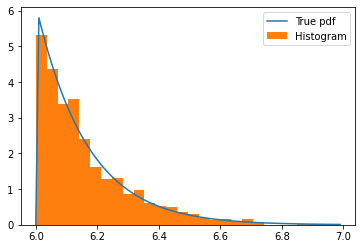

In [10]:
def truncatedgauss(x,q,p):
    return sps.norm.pdf(x)*(x>q)/p

x_pdf = np.linspace(q, max(X), num=100)

plt.plot(x_pdf, truncatedgauss(x_pdf,q,p), label="True pdf")
plt.hist(X, bins="auto", density=True, label="Histogram") 
plt.legend();

#### Question 1.3 ####
We still consider the values $q=3$, $n=100$, $\rho=0.9$, and $T=20$. Our goal is to illustrate the abovementioned CLT result. For this, apply $N=100$ times the previous method to get a sample of $N$ values of $\hat p_n$. Compare the empirical standard deviation of this sample to the theoretical standard deviation of the CLT. By using the function `sps.gaussian_kde()`, compare the empirical distribution of the  (centered and normalized) sample to the pdf of the $\mathcal{N}(0,1)$ law.  

Duration (s): 4.0
The empirical standard deviation is 3.67e-04
The theoretical standard deviation is 3.47e-04


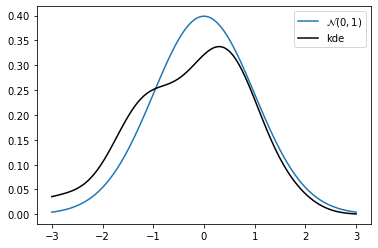

In [11]:
N = 100
n = 100
rho = 0.9
T = 20
q = 3
p = sps.norm.sf(q)

t0 = perf_counter()
phat = np.zeros(N)

def kernel(l,rho,T,Xnew):
    gauss = np.sqrt(1-rho**2)*sps.norm.rvs(size=T)
    for it in range(T):
        Y = rho*Xnew+gauss[it]
        if(Y>l): Xnew = Y
    return Xnew

for it in range(N):
    X = sps.norm.rvs(size=n)
    L = min(X)
    I = np.argmin(X)
    J = 0

    while L<q:
        Iprime = I
        while(Iprime == I):
            Iprime = np.random.randint(n)
        X[I] = kernel(L,rho,T,X[Iprime])
        L = min(X)
        I = np.argmin(X)
        J += 1
            
    phat[it] = (1-1/n)**J
    
empiricalsd = np.std(phat)  
theoreticalsd = np.sqrt(-p**2*np.log(p)/n)

print(f"Duration (s): {perf_counter()-t0:1.1f}")
print(f"The empirical standard deviation is {empiricalsd:1.2e}")
print(f"The theoretical standard deviation is {theoreticalsd:1.2e}")

phatnorm = np.sqrt(n)*(phat-p)/(phat*np.sqrt(-np.log(phat)))
kde = sps.gaussian_kde(phatnorm)
x_pdf = np.linspace(-3, 3, num=100)

plt.plot(x_pdf, sps.norm.pdf(x_pdf), label=r"$\mathcal{N}(0,1)$")
plt.plot(x_pdf, kde(x_pdf), color="black", label="kde")
plt.legend();

#### Question 1.4 ####
We now address the reverse problem, meaning that for a given (low) probability p, we want to estimate the $(1-p)$-associated quantile $q$, i.e. $\mathbb{P}(\mathcal{N}(0,1)>q)=p$. To do so, it suffices to apply the previous algorithm until step $j_n:= \lceil \frac{\log p}{\log (1-n^{-1})}\rceil$ and set 
$$\hat q_n:=L_{j_n}.$$
In an ideal case, if $\varphi$ stands for the pdf of the $\mathcal{N}(0,1)$, we have
$$\sqrt{n}(\hat{q}_n-q)\xrightarrow[n\to\infty]{\textrm{law}}\mathcal{N}\left(0,\frac{-p^2\log p}{\varphi(q)^2}\right).$$
If we denote
$$\hat\sigma_n:=\frac{p\sqrt{-\log p}}{\varphi(\hat{q}_n)},$$
this allows us to deduce asymptotic confidence intervals. 

For $p=10^{-6}$, $n=100$, $\rho=0.9$, and $T=20$, implement the algorithm to estimate $q$ such that $\mathbb{P}(\mathcal{N}(0,1)>q)=p$, together with a $95\%$ asymptotic confidence interval. 

In [27]:
n = 1000
rho = 0.9
T = 20
p = 10**(-6)
alpha = 0.05
q = sps.norm.ppf(1-p)
jn = int(np.ceil(np.log(p)/np.log(1-1/n)))

def kernel(l,rho,T,Xnew):
    gauss = np.sqrt(1-rho**2)*sps.norm.rvs(size=T)
    for it in range(T):
        Y = rho*Xnew+gauss[it]
        if(Y>l): Xnew = Y
    return Xnew

t0 = perf_counter()
X = sps.norm.rvs(size=n)
L = min(X)
I = np.argmin(X)

for j in range(1,1+jn):
    Iprime = I
    while(Iprime == I):
        Iprime = np.random.randint(n)
    X[I] = kernel(L,rho,T,X[Iprime])
    L = min(X)
    I = np.argmin(X)
        
qhat = L
sigmahat = p*np.sqrt(-np.log(p))/sps.norm.pdf(qhat)

lowerbound = qhat - sps.norm.ppf(1-alpha/2)*sigmahat/np.sqrt(n)
upperbound = qhat + sps.norm.ppf(1-alpha/2)*sigmahat/np.sqrt(n)

print(f"Duration (s): {perf_counter()-t0:1.1f}")
print(f"The true quantile is {q:1.2f}")
print(f"The estimate is {qhat:1.2f}")
print(f"Asymptotic confidence interval: [{lowerbound:1.2f},{upperbound:1.2f}]")

Duration (s): 1.6
The true quantile is 4.75
The estimate is 4.73
Asymptotic confidence interval: [4.69,4.77]


#### Question 1.5 ####
In most situations, we do not know the value $\varphi(q)$ at the denominator of the TCL
$$\sqrt{n}(\hat{q}_n-q)\xrightarrow[n\to\infty]{\textrm{law}}\mathcal{N}\left(0,\frac{-p^2\log p}{\varphi(q)^2}\right).$$
However, if
$$j_n^\pm:= -n\log p\pm1.96\sqrt{-n\log p}$$
then a $95\%$ asymptotic confidence interval is 
$$\left[L_{\lfloor j_n^-\rfloor},L_{\lceil j_n^+\rceil}\right].$$
To illustrate this result, apply $N=100$ times the previous algorithm to obtain $N$ asymptotic confidence intervals, and print the proportion of times that the true value $q$ belongs to the confidence interval. 

In [6]:
N = 100
n = 100
rho = 0.9
T = 20
q = 3
p = sps.norm.sf(q)
alpha = 0.05
jn = int(np.ceil(np.log(p)/np.log(1-1/n)))
jnminus = int(np.floor(-n*np.log(p)-sps.norm.ppf(1-alpha/2)*np.sqrt(-n*np.log(p))))
jnplus = int(np.ceil(-n*np.log(p)+sps.norm.ppf(1-alpha/2)*np.sqrt(-n*np.log(p))))

t0 = perf_counter()
qhat = np.zeros(N)
qhatminus = np.zeros(N)
qhatplus = np.zeros(N)
CIcounter = 0

def kernel(l,rho,T,Xnew):
    gauss = np.sqrt(1-rho**2)*sps.norm.rvs(size=T)
    for it in range(T):
        Y = rho*Xnew+gauss[it]
        if(Y>l): Xnew = Y
    return Xnew

for it in range(N):
    X = sps.norm.rvs(size=n)
    L = min(X)
    I = np.argmin(X)

    for j in range(1,1+jnminus):
        Iprime = I
        while(Iprime == I):
            Iprime = np.random.randint(n)
        X[I] = kernel(L,rho,T,X[Iprime])
        L = min(X)
        I = np.argmin(X)
        
    qhatminus[it] = L 
        
    for j in range(1+jnminus,1+jnplus):
        Iprime = I
        while(Iprime == I):
            Iprime = np.random.randint(n)
        X[I] = kernel(L,rho,T,X[Iprime])
        L = min(X)
        I = np.argmin(X)    
        
    qhatplus[it] = L
    
    if q > qhatminus[it] and q < qhatplus[it]:
        CIcounter += 1
        
proportion = 100 * CIcounter/N

print(f"Duration (s): {perf_counter()-t0:1.1f}")
print(f"Percentage of times the true value q is in the confidence interval: {proportion}")

Duration (s): 4.3
Percentage of times the true value q is in the confidence interval: 94.0


## Part 2: The Dynamic Framework

In dimension 1, let us consider the SDE 
$$dX(t)=-V'(X(t)) dt + \sqrt{2 \varepsilon}\ dB(t)$$
where $V:\mathbb R \to \mathbb R$ is a potential function, $\varepsilon >0$ is a fixed parameter and $(B(t))_{t \ge 0}$ stands for a standard Brownian motion. For two real numbers $a<b$, let $\tau_a= \inf\{t \ge 0, X(t)<a\}$ and $\tau_b= \inf\{t \ge 0, X(t)>b\}$. Given a fixed initial condition $X(0)=x_0 \in (a,b)$, our goal is to estimate
$$p=\mathbb P(\tau_b < \tau_a).$$

In this aim, we denote the timestep $\delta_t>0$ and the following discretization scheme: for all $k \ge 0$,
$$X_{k+1} = X_k - V'(X_k) \delta_t + \sqrt{2 \varepsilon \delta_t}\ G_k$$
where $(G_k)_{k \ge 0}$ is a sequence of i.i.d. standard Gaussian variables. Thus, we end up with the trajectory $(X_k)_{0 \le k \le T_a \wedge T_b}$ where $T_a=\min\{k\ge 0, \, X_k < a\}$ and $T_b=\min\{k\ge 0, \, X_k > b\}$.

#### Question 2.0 #### 
Plot the graph of the double-well potential $V(x)=\frac{x^4}{4}-\frac{x^2}{2}$ for $x\in[-1.5;1.5]$.

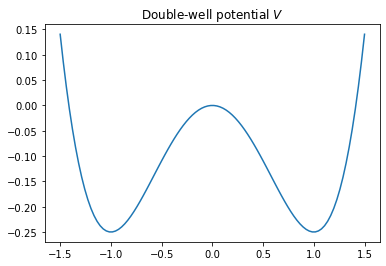

In [13]:
def V(x):
    return x**4/4-x**2/2

x = np.linspace(-1.5, 1.5, num=100)

plt.plot(x, V(x))
plt.title("Double-well potential $V$");

#### Question 2.1 #### 
Simulate and plot a trajectory $(X_k)_{0 \le k \le T_a \wedge T_b}$ for the previous potential $V$ and the following values of the parameters: $a=-0.9$, $b=0.9$, $x_0=-0.89$, $\varepsilon=0.02$, and $\delta_t=0.001$. 

Maximum of the trajectory: -0.852


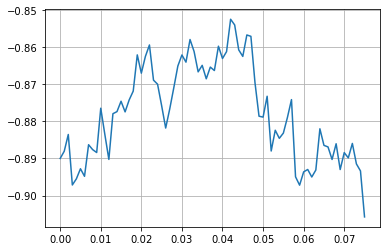

In [15]:
a = -0.9
b = 0.9
x0 = -0.89
epsilon = 0.02
dt = 0.001
sigma = np.sqrt(2*epsilon*dt)

def Vprime(x):
    return x**3-x

def plot_X(traj):
    l = traj.size
    duration = np.arange(l)*dt
    plt.plot(duration, traj)
    plt.grid()

X = [x0]
while X[-1]>=a and X[-1]<=b:
    X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())

X = np.asarray(X)
    
plot_X(X)
Xmax = X.max()
print(f"Maximum of the trajectory: {Xmax:1.3f}")

#### Question 2.2 #### 
Estimate $p=\mathbb P(T_b<T_a)$ thanks to a naive Monte Carlo method (together with a $95\%$ asymptotic confidence interval) for a sample size  $n=1000$, first for $\varepsilon=1$, then for $\varepsilon=0.02$.

In [17]:
epsilon = 0.02
alpha = 0.05
sigma = np.sqrt(2*epsilon*dt)
n = 1000 

t0 = perf_counter()
counter = 0

for i in range(n):
    X = x0
    while X>=a and X<=b:
        X = X-Vprime(X)*dt+sigma*sps.norm.rvs()
    if X>b:
        counter += 1
        
phat = counter/n
radius = sps.norm.ppf(1-alpha/2)*np.sqrt(phat*(1-phat)/n)
lowerbound = phat-radius
upperbound = phat+radius

print(f"Duration (s): {perf_counter()-t0:1.1f}")
print(f"Estimation of the probability : {phat:1.2e}")
print(f"Asymptotic confidence interval: [{lowerbound:1.2e},{upperbound:1.2e}]")

Duration (s): 1.5
Estimation of the probability : 0.00e+00
Asymptotic confidence interval: [0.00e+00,0.00e+00]


#### Question 2.3 #### 
From now on, we apply the AMS algorithm. The initialization is as follows:
* Simulate a list of $n$ trajectories $(X^i_k)_{0 \le k \le T_a \wedge T_b}$, for $0 \le i \le n-1$,
* Compute the first level $L_1=\min_{0 \le i \le n-1}\max_{0 \le k \le T_a \wedge T_b} X^i_k$,
* Determine the indices of the trajectories to be killed: $\mathcal K=\{0 \le i \le n-1,\ \max_{0 \le k \le T_a \wedge T_b}X^i_k=L_1\}$,
* Initialize the probability estimate : $\hat p_n=1-\frac{|\mathcal K|}{n}$.

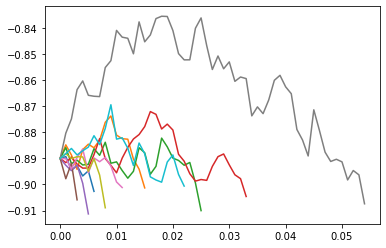

In [19]:
epsilon = 0.02
n = 10
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
p = 1

for i in range(n):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.array(X)
    X_AMS.append(X)

S = np.zeros(n)

for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
p *= (1-K.size/n)
    
for i in range(n):
    plot_X(X_AMS[i]) 

#### Question 2.4 #### 
Next, for each iteration, while $L \le b$ and for each $i\in \mathcal K$:
* Sample (randomly and uniformly) an index  $I'$ in $\{0,\ldots,n-1\} \setminus \mathcal K$
* Copy the trajectory $X^{I'}$ on $X^{i}$ until the first time $k$ such that $X^{I'}_k> L$ (beware to the strict inequality)
* Complete this trajectory until time $T_a \wedge T_b$
* Update $L$, $\mathcal K$ and the estimate $\hat p_n \leftarrow \left(1-\frac{|\mathcal K|}{n}\right)\hat p_n$

Implement this method for $\varepsilon=1$ and for $\varepsilon=0.02$, with $n=100$. For the asymptotic confidence interval, we will consider that only one trajectory is killed at each step so that, as in the first part, we have
$$\sqrt{n}\left(\hat p_n-p\right)\xrightarrow[n\to\infty]{\textrm{law}}\mathcal{N}(0,-p^2\log p).$$

In [24]:
epsilon = 0.005
alpha = 0.05
n = 200
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

for i in range(n):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    X_AMS.append(X)

S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    #print(f"level={L:1.4f}")
    for i in K:
        Iprime = i
        while(Iprime in K):
            Iprime = np.random.randint(n)
        n0 = np.argmax(X_AMS[Iprime]>L) 
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()
    #print("cardinal of K =",K.size)
    phat *= (1-K.size/n)
    
    #clear_output(wait=True)
    #sleep(.2)
    #plot of the trajectories
    #for i in range(n):
    #    plot_X(X_AMS[i])
    #plt.show()
    
sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
lowerbound = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
upperbound = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Duration (s): {perf_counter()-t0:1.1f}")
print(f"The probability estimate is {phat:1.2e}")
print(f"Asymptotic confidence interval: [{lowerbound:1.2e},{upperbound:1.2e}]")

Duration (s): 380.3
The probability estimate is 5.81e-23
Asymptotic confidence interval: [4.84e-25,1.16e-22]


#### Question 2.5 #### 
In our setting, we can prove that the duration $D$ of a reactive trajectory satisfies
$$D+\log\varepsilon\xrightarrow[\varepsilon\to 0]{\textrm{law}} G+c$$
where $G$ has a standard Gumbel distribution and
$$c=\log(0.89 × 0.9)−\frac{1}{2}\log(1 − 0.89^2)−\frac{1}{2}\log(1 − 0.9^2).$$
Roughly speaking, this means that, for $\varepsilon$ low enough,
$$D\overset{\textrm{law}}{\approx} G-\log\varepsilon+c$$
Use the code of the previous question to illustrate this result for $n=200$ and $\varepsilon=0.005$. This might take a few minutes...

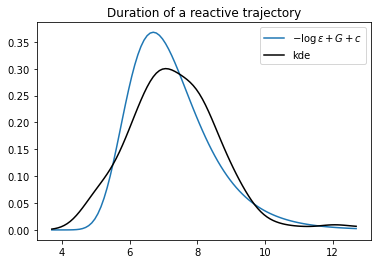

In [25]:
duration = np.zeros(n)
c = np.log(0.89*0.9)-0.5*np.log(1-0.89**2)-0.5*np.log(1-0.9**2)

for i in range(n):
    duration[i]=np.size(X_AMS[i])*dt

kde = sps.gaussian_kde(duration)
t = np.linspace(-3-np.log(epsilon)+c, 6-np.log(epsilon)+c, num=100)

plt.plot(t, sps.gumbel_r.pdf(t+np.log(epsilon)-c), label=r"$-\log\varepsilon+G+c$")
plt.plot(t, kde(t), color="black",label="kde")
plt.title("Duration of a reactive trajectory")
plt.legend();

**Remark** : The theoretical result about the convergence toward a Gumbel distribution is established in   
F. Cérou, A. Guyader, T. Lelièvre, and F. Malrieu, [On the Length of One-Dimensional Reactive Paths](https://perso.lpsm.paris/~aguyader/files/papers/cglm.pdf), *ALEA*, 2013.
